# Image Segmentation

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

# Libraries

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

# Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [2]:
path = untar_data(URLs.CAMVID, dest="/home/ubuntu/datasets/")

In [3]:
!ls -l $path

total 72
-rw-rw-r-- 1 ubuntu ubuntu   313 Oct 26  2018 codes.txt
drwxrwxr-x 2 ubuntu ubuntu 32768 Oct 26  2018 images
drwxrwxr-x 2 ubuntu ubuntu 32768 Oct 26  2018 labels
-rw-rw-r-- 1 ubuntu ubuntu  1717 Oct 26  2018 valid.txt


In [4]:
# Let's get image count
!ls -l $path/images | wc -l

703


In [5]:
# label counts
!ls -l $path/labels | wc -l

702


In [6]:
!ls -l $path/images | head -n 5

total 574444
-rw-rw-r-- 1 ubuntu ubuntu  629212 Oct 26  2018 0001TP_006690.png
-rw-rw-r-- 1 ubuntu ubuntu  632750 Oct 26  2018 0001TP_006720.png
-rw-rw-r-- 1 ubuntu ubuntu  637981 Oct 26  2018 0001TP_006750.png
-rw-rw-r-- 1 ubuntu ubuntu  657148 Oct 26  2018 0001TP_006780.png
ls: write error: Broken pipe


Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:

In [7]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [8]:
valid_fnames[:5], valid_fnames[-5:]

(['0016E5_07959.png',
  '0016E5_07961.png',
  '0016E5_07963.png',
  '0016E5_07965.png',
  '0016E5_07967.png'],
 ['0016E5_08153.png',
  '0016E5_08155.png',
  '0016E5_08157.png',
  '0016E5_08159.png',
  ''])

Let's look at an image and see how everything aligns up

In [9]:
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames

In [10]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them

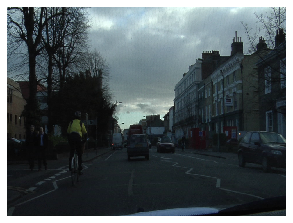

In [11]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`

In [12]:
# pass img_name and get mask file name
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

In [13]:
img_fn

Path('/home/ubuntu/datasets/camvid/images/0001TP_007380.png')

In [14]:
o = img_fn
o.stem, o.suffix, type(o)

('0001TP_007380', '.png', pathlib.PosixPath)

In [15]:
# other attributes available on PosixPath, similar to suffix and stem
str(dir(img_fn))

"['__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__fspath__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rtruediv__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__truediv__', '_accessor', '_cached_cparts', '_closed', '_cparts', '_drv', '_flavour', '_format_parsed_parts', '_from_parsed_parts', '_from_parts', '_hash', '_init', '_make_child', '_make_child_relpath', '_opener', '_parse_args', '_parts', '_pparts', '_raise_closed', '_raw_open', '_root', '_str', 'absolute', 'anchor', 'as_posix', 'as_uri', 'chmod', 'cwd', 'drive', 'exists', 'expanduser', 'glob', 'group', 'home', 'is_absolute', 'is_block_device', 'is_char_device', 'is_dir', 'is_fifo', 'is_file', 'is_mount', 'is_reserved', 'is_socket', 'is_symlink', 'iterdir', 'joinpath', 'lchmod', 'load', 'loa

In [16]:
# Let's try a few of those
o.parent, o.owner, o.lstat()

(Path('/home/ubuntu/datasets/camvid/images'),
 <bound method Path.owner of Path('/home/ubuntu/datasets/camvid/images/0001TP_007380.png')>,
 os.stat_result(st_mode=33204, st_ino=35392858, st_dev=66306, st_nlink=1, st_uid=1000, st_gid=1000, st_size=765949, st_atime=1582593708, st_mtime=1540577519, st_ctime=1582593181))

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

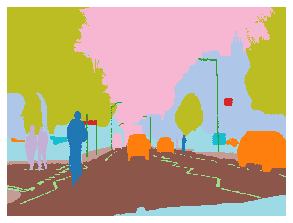

In [17]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [18]:
tensor(msk)

tensor([[26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        ...,
        [17, 17, 17,  ..., 30, 30, 30],
        [17, 17, 17,  ..., 30, 30, 30],
        [17, 17, 17,  ..., 30, 30, 30]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [19]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.

In [20]:
img_fn

Path('/home/ubuntu/datasets/camvid/images/0001TP_007380.png')

In [21]:
img_fn.name

'0001TP_007380.png'

In [22]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

# Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [23]:
sz = msk.shape; sz

(720, 960)

In [24]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [25]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [26]:
dls = camvid.dataloaders(path/'images', bs=4)

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

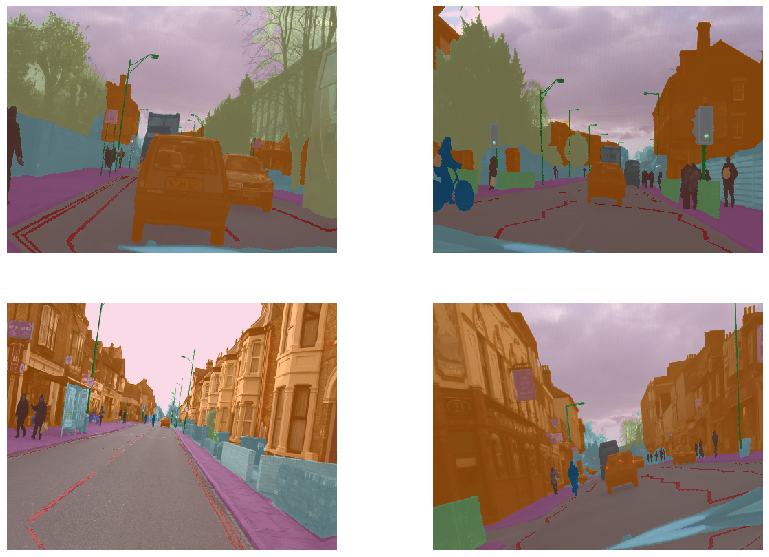

In [27]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [28]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [29]:
name2id = {v:k for k,v in enumerate(codes)}

In [30]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function

In [31]:
void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [32]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

In [33]:
config = unet_config(self_attention=True, act_cls=Mish)

Along with this we will use the `Ranger` activation function

In [34]:
opt = ranger

In [35]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)

In [36]:
learn.summary()

DynamicUnet (Input shape: ['4 x 3 x 360 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               4 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          4 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 4 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            4 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               4 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          4 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 4 x 64 x 90 x 120    0          False     
_________________________________________________

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

(0.0009120108559727668, 0.0020892962347716093)

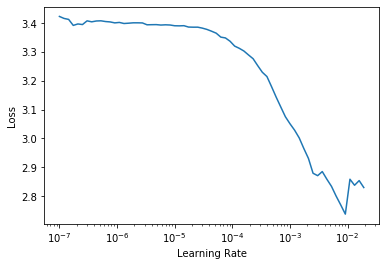

In [37]:
learn.lr_find()

In [38]:
lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [39]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.833227,0.546740,0.858252,01:00
1,0.607849,0.449407,0.876305,01:00
2,0.537033,0.411488,0.888101,01:00
3,0.450401,0.337837,0.907343,01:00
4,0.410166,0.350964,0.898582,01:01
5,0.381980,0.327696,0.904392,01:00
6,0.357967,0.308426,0.914065,01:00
7,0.333561,0.324149,0.907739,01:00
8,0.288273,0.286977,0.921352,01:00
9,0.259074,0.278543,0.921553,01:00


In [40]:
learn.save('stage-1')
learn.load('stage-1');

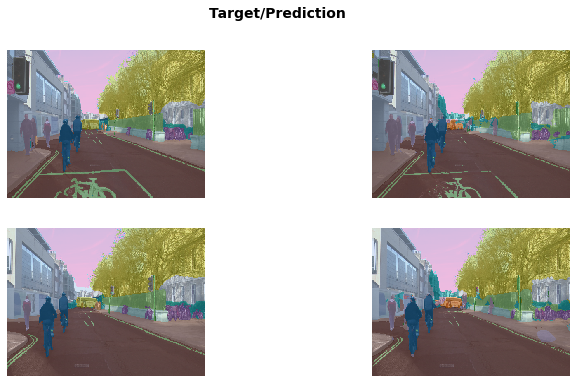

In [41]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [42]:
lrs = slice(lr/400, lr/4)

In [43]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [44]:
learn.unfreeze()

And train for a bit more

In [45]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.248264,0.276256,0.920297,01:03
1,0.243340,0.271918,0.920875,01:03
2,0.229999,0.271620,0.923995,01:03
3,0.229212,0.270561,0.922672,01:03
4,0.218898,0.275545,0.921804,01:03
5,0.216502,0.268700,0.922517,01:03
6,0.206222,0.265800,0.923274,01:03
7,0.203801,0.270829,0.922946,01:03
8,0.196827,0.260287,0.926827,01:03
9,0.192382,0.262153,0.926197,01:03


Now let's save that model away

In [46]:
learn.save('stage_2')

And look at a few results

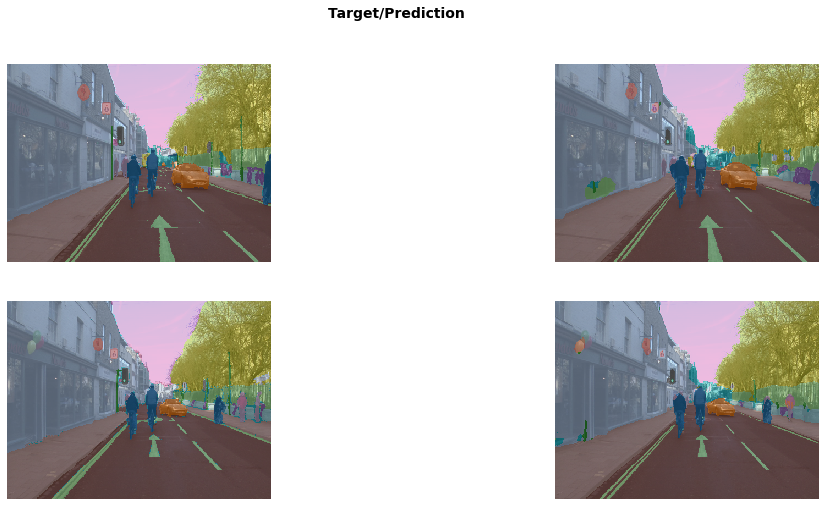

In [47]:
learn.show_results(max_n=4, figsize=(18,8))

# Inference

Let's take a look at how to do inference with `test_dl`

Let's do the first five pictures

In [48]:
# compared to pred, this offers batch input for inference
dl = learn.dls.test_dl(fnames[:5])

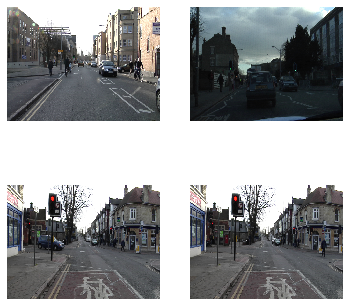

In [49]:
dl.show_batch()

In [50]:
preds = learn.get_preds(dl=dl)

In [51]:
preds[0].shape

torch.Size([5, 32, 360, 480])

Alright so we have a 5x32x360x480

In [52]:
len(codes)

32

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [53]:
pred_1 = preds[0][0]

In [54]:
pred_1.shape

torch.Size([32, 360, 480])

Now let's take the argmax of our values

In [55]:
# across all 32 categories, lets select index of max values
pred_arx = pred_1.argmax(dim=0)

In [56]:
pred_arx.shape

torch.Size([360, 480])

And look at it

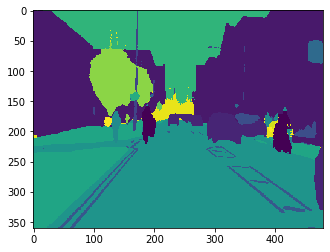

In [57]:
plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

In [58]:
pred_arx = pred_arx.numpy()

In [59]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [60]:
im = Image.fromarray(rescaled)

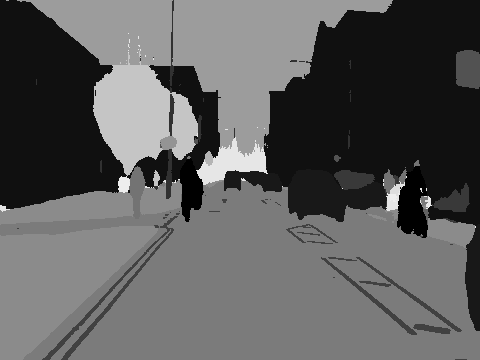

In [61]:
im

In [62]:
im.save('test.png')

Let's make a function to do so for our files

In [63]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [64]:
torch.save(preds[0][0], 'Image_1.pt')

In [65]:
pred_1 = torch.load('Image_1.pt')

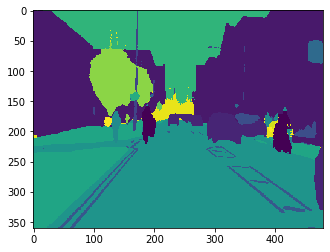

In [66]:
plt.imshow(pred_1.argmax(dim=0))

# Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

In [3]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size

In [4]:
sz = (720, 960)

In [5]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory

In [6]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights

In [7]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [9]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('stage_2');

And now let's find our learning rate and train!

(7.585775847473997e-08, 5.248074330665986e-07)

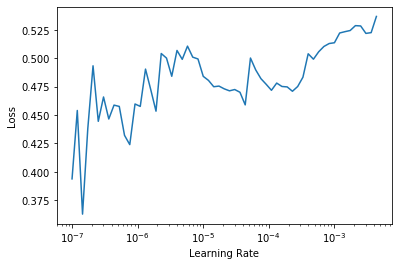

In [10]:
learn.lr_find()

In [11]:
lr = 1e-3

In [12]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.473830,0.329460,0.914296,04:38
1,0.385507,0.329091,0.913016,04:39
2,0.385217,0.331826,0.904923,04:39
3,0.301821,0.279041,0.921734,04:39
4,0.283018,0.290749,0.926539,04:40
5,0.290880,0.306159,0.915216,04:39
6,0.259270,0.266397,0.927656,04:38
7,0.282720,0.294475,0.926138,04:37
8,0.202332,0.288254,0.924922,04:38
9,0.178863,0.264141,0.930576,04:43


In [13]:
learn.save('full_1')

In [14]:
learn.unfreeze()

In [15]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 0.0001, None)

In [16]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.169775,0.252514,0.935060,04:54
1,0.179732,0.248506,0.932803,04:51
2,0.168369,0.248209,0.936167,04:54
3,0.168450,0.256722,0.932955,04:49
4,0.157546,0.267246,0.932674,04:52
5,0.145236,0.264396,0.933177,04:56
6,0.153183,0.258591,0.934654,04:53
7,0.169463,0.264708,0.934136,04:56
8,0.151822,0.270994,0.932808,05:07
9,0.149269,0.272354,0.931518,05:10


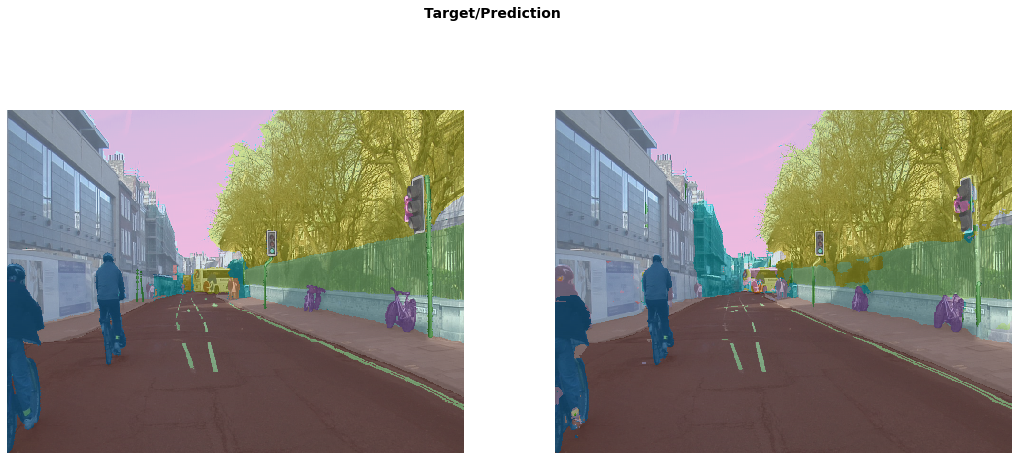

In [17]:
learn.show_results(max_n=4, figsize=(18,8))

In [18]:
learn.save('full_2')